In [1]:
import sys, os
sys.path.insert(0, os.path.join(os.getcwd(), '..'))
import vmlab

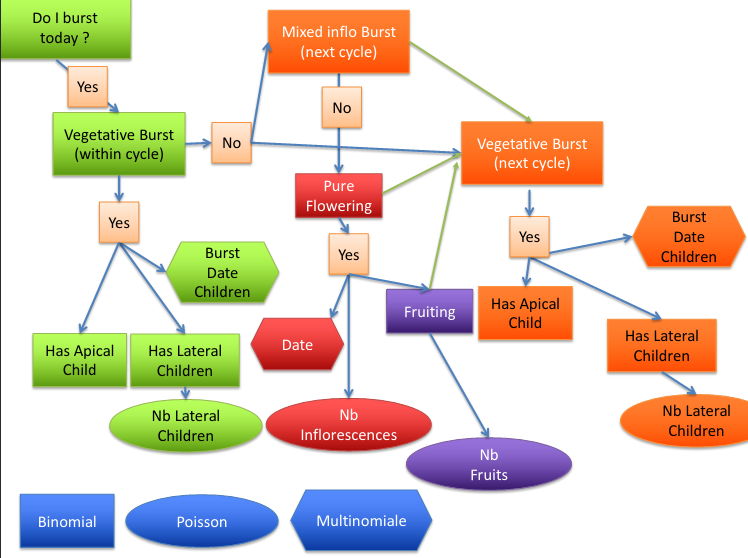

In [2]:
from IPython.display import Image
Image('growth.png')

In [3]:

import xsimlab as xs
import numpy as np
import pandas as pd


In [4]:
@xs.process
class Environment:
    cycle = xs.variable(intent='out')
    end_of_vegetative_cycle = xs.variable(dims='month', intent='in')
    
    def initialize(self):
        self.cycle = 4
    
    @xs.runtime(args=('step', 'step_start'))
    def run_step(self, step, step_start):
        self.cycle = self.cycle + 1 if self.end_of_vegetative_cycle else self.cycle

@xs.process
class Topology:
    gu = xs.index(dims='gu')
    adjacency = xs.variable(intent='out', dims=('gu', 'gu'))
    gu_burst_date = xs.variable(intent='out', dims='gu')
    gu_position = xs.variable(intent='out', dims='gu')
    gu_cycle = xs.variable(intent='out', dims='gu')
    cycle = xs.foreign(Environment, 'cycle')
    bursted = xs.variable(intent='out', dims='gu')
    
    def initialize(self):
        self.gu = np.array([f'GU{i}' for i in range(0, 1)], dtype=np.dtype('<U10'))
        self.bursted = np.full(self.gu.shape, False)
        
    @xs.runtime(args=('step'))
    def run_step(self, step):
        self.gu = np.array([f'GU{i}' for i in range(0, step)], dtype=np.dtype('<U10'))
        

In [5]:
@xs.process
class HasVegChildrenInItsCycle:
    file = xs.variable(intent='in', static=True)
    
    has_veg_children_in_its_cycle = xs.variable(intent='out', dims='gu', static=True)
    adjacency = xs.foreign(Topology, 'adjacency')
    bursted = xs.foreign(Topology, 'bursted')
    gu = xs.foreign(Topology, 'gu')
    
    def initialize(self):
        self.has_veg_children_in_its_cycle = np.full(self.gu.shape, False)   
    
    @xs.runtime(args=('step'))
    def run_step(self, step):
        self.has_veg_children_in_its_cycle[self.bursted] = True
        
        
@xs.process
class BurstDateChildren:
    file = xs.variable(intent='in', static=True)
    
    burst_date_children = xs.variable(intent='out', dims='gu')
    has_veg_children_in_its_cycle = xs.foreign(HasVegChildrenInItsCycle, 'has_veg_children_in_its_cycle')
    
    @xs.runtime(args=('step'))
    def run_step(self, step):
        pass
    
    
@xs.process
class HasApicalChild:
    file = xs.variable(intent='in', static=True)
    
    has_apical_child = xs.variable(intent='out', dims='gu')
    has_veg_children_in_its_cycle = xs.foreign(HasVegChildrenInItsCycle, 'has_veg_children_in_its_cycle')
    
    @xs.runtime(args=('step'))
    def run_step(self, step):
        pass
    
    
@xs.process
class HasLateralChildren:
    file = xs.variable(intent='in', static=True)
    
    has_lateral_children = xs.variable(intent='out', dims='gu')
    has_veg_children_in_its_cycle = xs.foreign(HasVegChildrenInItsCycle, 'has_veg_children_in_its_cycle')
    
    @xs.runtime(args=('step'))
    def run_step(self, step):
        pass
    
@xs.process
class NumberLateralChildren:
    file = xs.variable(dims=(), intent='in', static=True)
    
    nb_lateral_children = xs.variable(intent='out', dims='gu')
    has_lateral_children = xs.foreign(HasLateralChildren, 'has_lateral_children')
    
    @xs.runtime(args=('step'))
    def run_step(self, step):
        pass
    

In [6]:
model = xs.Model({
    cls.__name__: cls for cls in [
        Environment,
        Topology,
        HasVegChildrenInItsCycle,
        BurstDateChildren,
        HasApicalChild,
        HasLateralChildren,
        NumberLateralChildren
    ]
})

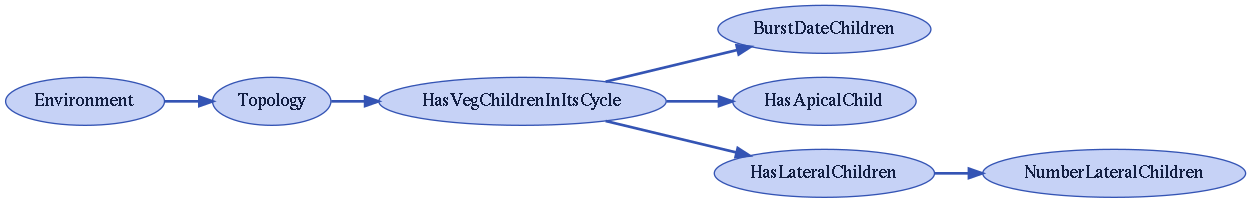

In [7]:
model.visualize(show_variables=False)

In [10]:
clock = pd.date_range(start='2002-09-01', end='2005-09-01', freq="1M")
ds = xs.create_setup(
    model=model,
    clocks={
        'month': clock
    },
    input_vars={
        'Environment': {
            'end_of_vegetative_cycle': (clock.month == 6)
        },
        'HasVegChildrenInItsCycle': {
            'file': '../share/probability_tables/interaction_glm/'
        },
        'BurstDateChildren': {
            'file': '../share/probability_tables/interaction_glm/'
        },
        'HasApicalChild': {
            'file': '../share/probability_tables/interaction_glm/'
        },
        'HasLateralChildren': {
            'file': '../share/probability_tables/interaction_glm/'
        },
        'NumberLateralChildren': {
            'file': '../share/probability_tables/interaction_glm/'
        }
    },
    output_vars={
        'Environment': {
            'cycle': 'month'
        },
        'Topology': {
            'bursted': 'month'
        },
        'HasVegChildrenInItsCycle': {
            'has_veg_children_in_its_cycle': None
        }
    }
)

In [11]:
ds.xsimlab.run(model, decoding={ 'mask_and_scale': False })

<xarray.Dataset>
Dimensions:                                                  (gu: 34, month: 36)
Coordinates:
  * gu                                                       (gu) <U10 'GU0' ...
  * month                                                    (month) datetime64[ns] ...
Data variables:
    BurstDateChildren__file                                  <U44 '../share/p...
    Environment__cycle                                       (month) int64 4 ...
    Environment__end_of_vegetative_cycle                     (month) bool Fal...
    HasApicalChild__file                                     <U44 '../share/p...
    HasLateralChildren__file                                 <U44 '../share/p...
    HasVegChildrenInItsCycle__file                           <U44 '../share/p...
    HasVegChildrenInItsCycle__has_veg_children_in_its_cycle  (gu) bool False ...
    NumberLateralChildren__file                              <U44 '../share/p...
    Topology__bursted                                        (month, gu) bool ...